# Problématique

<h3> Prédire le nombre de lettres dans l'image (régression)</h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : MLP
- Évaluation du modèle : MAE métrique


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists

In [2]:
import letter_detection_utils as ld_util
from importlib import reload 
import warnings

# Ensure we have always the latest state and 
# not the last import in memory
reload(ld_util)

<module 'letter_detection_utils' from '/Users/jpec/Prog/OCRpyMAN/notebooks/letter_detection_utils.py'>

# Chargement du dataframe

In [3]:
img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    # pickle_name='ld_sobel_y', 
    img_size=img_size,
    with_edge_detection = False
)

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

Loading existing data from  ../pickle/letter_detection_data.pickle ...


In [4]:
print("Length: ", len(df))
print("Imgs length: ", len(preprocessed_imgs))
print("Img shape: ", preprocessed_imgs[0].shape)

Length:  1000
Imgs length:  1000
Img shape:  (4096,)


In [5]:
df.head(3)

,index,michelson_contrast,gray_level_mot,word_id,gray_level,x,y,w,h,transcription,word_img_path,form_img_path,length
0,944,0.758621,0.889522,a01-020u-06-05,170,1954,1831,389,100,studying,../data/words/a01/a01-020u/a01-020u-06-05.png,../data/formsA-D/a01-020u.png,8
1,914,0.695946,0.774799,a01-020u-02-06,169,1565,1129,128,49,has,../data/words/a01/a01-020u/a01-020u-02-06.png,../data/formsA-D/a01-020u.png,3
2,581,0.683168,0.830613,a01-011u-04-05,166,1622,1472,321,62,discuss,../data/words/a01/a01-011u/a01-011u-04-05.png,../data/formsA-D/a01-011u.png,7


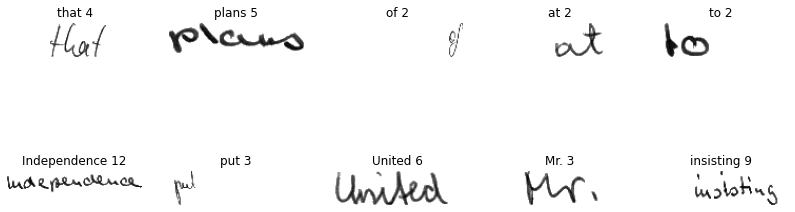

In [6]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=0, high=len(preprocessed_imgs), size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(preprocessed_imgs[i].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length))
    j+=1

# Data visualisation

Pour travailler avec les images et comparer le ratio hauteur/largeur, il faut au préalable rescale nos images.

In [51]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[-3:]

,transcription,length,w,word_img_path,form_img_path
79,Independence,12,586,../data/words/a01/a01-011u/a01-011u-01-02.png,../data/formsA-D/a01-011u.png
627,Protectorate's,14,605,../data/words/a01/a01-014x/a01-014x-01-05.png,../data/formsA-D/a01-014x.png
15,demonstrations,14,640,../data/words/a01/a01-014x/a01-014x-06-02.png,../data/formsA-D/a01-014x.png


In [52]:
df[['transcription', 'length', 'w', 'word_img_path', 'form_img_path']].sort_values(by=['w']).iloc[:3]

,transcription,length,w,word_img_path,form_img_path
148,A,1,27,../data/words/a01/a01-000u/a01-000u-00-00.png,../data/formsA-D/a01-000u.png
673,is,2,30,../data/words/a01/a01-000x/a01-000x-01-05.png,../data/formsA-D/a01-000x.png
441,a,1,32,../data/words/a01/a01-000x/a01-000x-01-10.png,../data/formsA-D/a01-000x.png


Hypothèse: le nombre de caractère est proportionnel à la largeur des boîtes.

In [53]:
df['length'].describe()

count    1000.00000
mean        4.84800
std         2.48658
min         1.00000
25%         3.00000
50%         4.00000
75%         7.00000
max        15.00000
Name: length, dtype: float64

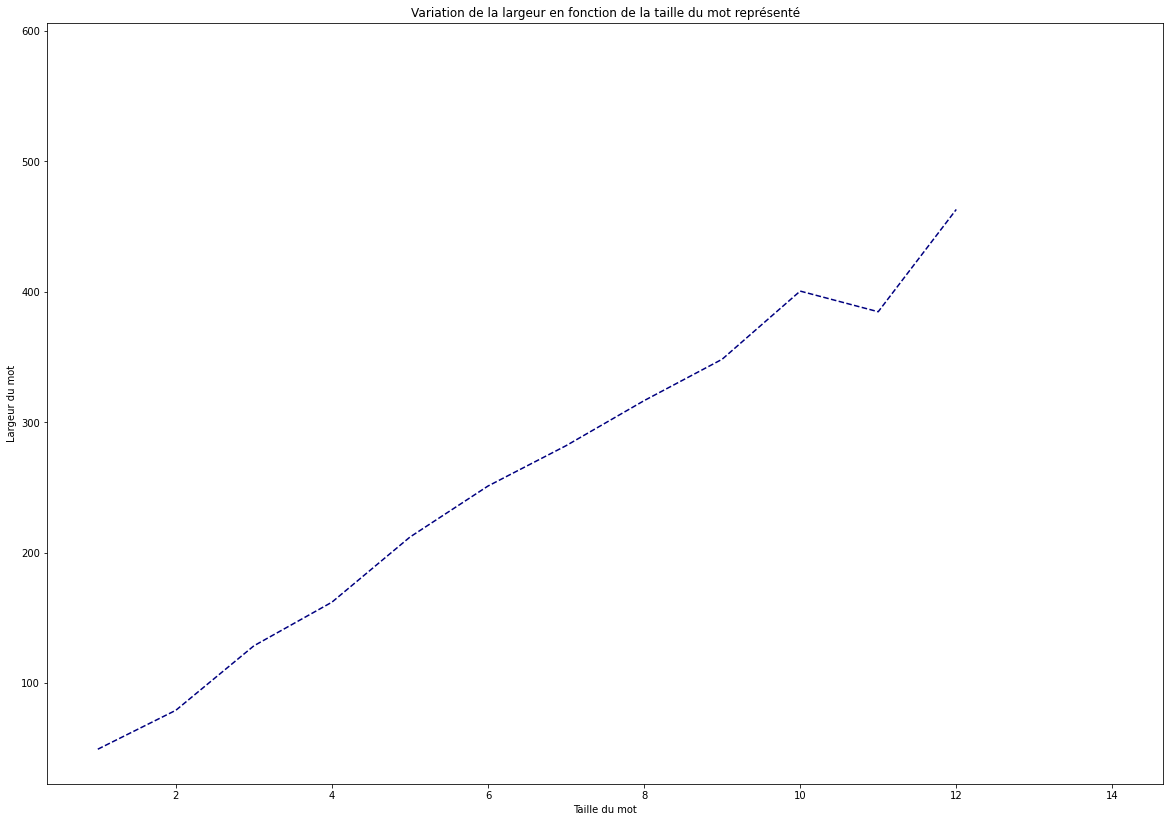

In [54]:
ld_util.plot_avg_width_per_string_length(df)

# Model

In [7]:
from sklearn.model_selection import train_test_split


target = df['length'].to_numpy()
# We do not shuffle to have X_train[index] to match df[index]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_imgs, target, test_size=0.2, shuffle=False)

## Manual MLP

In [13]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from keras.utils import to_categorical



inputs = Input(shape=(X_train.shape[1]))
first_layer = Dense(16, activation='tanh', name='Dense_1')
second_layer = Dense(24, activation='tanh', name='Dense_2')
third_layer = Dense(26 * 2, activation='softmax', name='Dense_3')

outputs=first_layer(inputs)
outputs=second_layer(outputs)
outputs=third_layer(outputs)
model = Model(inputs = inputs, outputs = outputs)


In [14]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
Dense_1 (Dense)              (None, 16)                65552     
_________________________________________________________________
Dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
Dense_3 (Dense)              (None, 52)                1300      
Total params: 67,260
Trainable params: 67,260
Non-trainable params: 0
_________________________________________________________________


In [15]:
import tensorflow as tf

# mae = tf.keras.losses.MeanAbsoluteError()
# loss='sparse_categorical_crossentropy'
mae = tf.keras.metrics.mean_absolute_error()
model.compile(loss=mae, metrics=['mean_absolute_error'], optimizer='adam')
training_history = model.fit(X_train, y_train, batch_size=5, epochs=16)


Train on 800 samples
Epoch 1/16
800/800 [==============================] - 1s 972us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 2/16
800/800 [==============================] - 0s 600us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 3/16
800/800 [==============================] - 0s 471us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 4/16
800/800 [==============================] - 0s 545us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 5/16
800/800 [==============================] - 0s 567us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 6/16
800/800 [==============================] - 1s 785us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 7/16
800/800 [==============================] - 0s 527us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 8/16
800/800 [==============================] - 0s 484us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 9/16
800/800 [==============================] - 0s 475us/sample - loss: 4.8170 - accuracy: 0.0000e+00
Epoch 1

In [16]:
training_history.history['loss']

[4.817019319534301,
 4.817019306123257,
 4.817019307613373,
 4.817019321024418,
 4.817019313573837,
 4.8170193374156955,
 4.817019313573837,
 4.8170193374156955,
 4.817019312083721,
 4.817019321024418,
 4.817019332945347,
 4.8170193284749985,
 4.817019316554069,
 4.817019319534301,
 4.817019344866276,
 4.817019322514534]

## MLP

### Without Grid Search

In [60]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    solver='lbfgs', 
    activation='relu',
    alpha=1e-4, 
    hidden_layer_sizes=(64, 256, 1024), 
    max_iter=10_000,
    random_state=42
)
# {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
mlp.fit(X_train, y_train)

print(mlp.score(X_test, y_test))
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

0.2


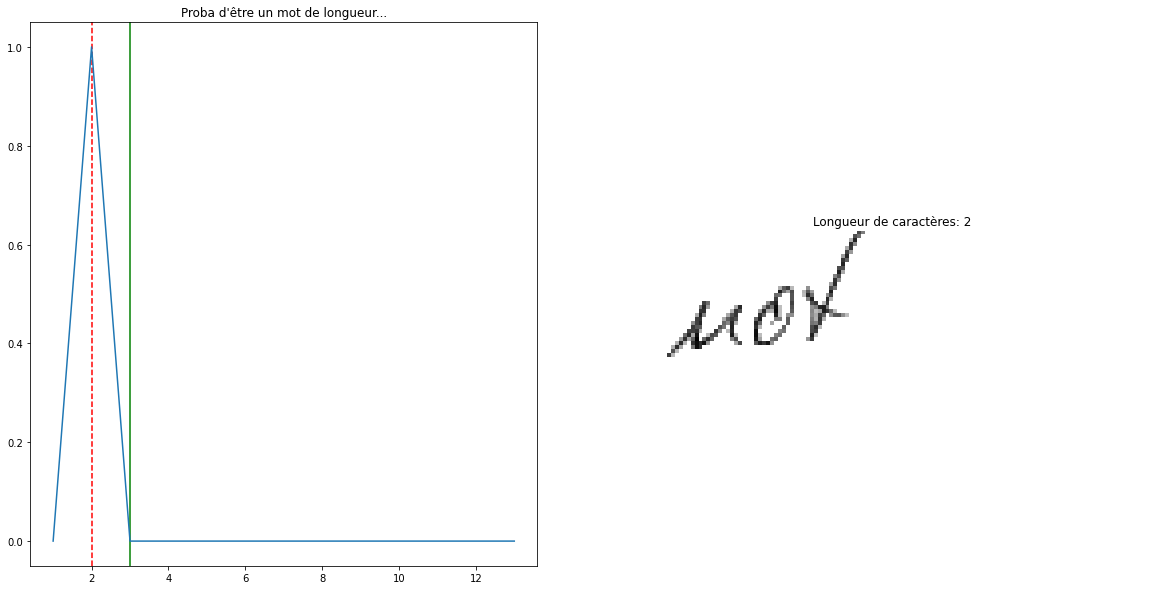

In [61]:
ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

## LeNet

In [30]:
X_train_lenet = X_train.reshape(-1, img_size[0], img_size[1], 1)
X_test_lenet = X_test.reshape(-1, img_size[0], img_size[1], 1)

X_train_lenet.shape

(800, 32, 128, 1)

In [ ]:
# inputs = Input(shape=(X_train_lenet.shape[1], X_train_lenet.shape[2],  X_train_lenet.shape[3]))
# conv_1 = Conv2D(filters = 32,                     # Nombre de filtres
#                 kernel_size = (5, 5),            # Dimensions du noyau
#                 padding = 'valid',               # Mode de Dépassement
#                 activation = 'relu')             # Fonction d'activation
# max_pool_1 = MaxPooling2D(pool_size = (2, 2))
# conv_2 = Conv2D(filters = 16,                    
#                 kernel_size = (3, 3),          
#                 padding = 'valid',             
#                 activation = 'relu')
# max_pool_2 = MaxPooling2D(pool_size = (2, 2))
# flatten = Flatten()
# dropout = Dropout(rate = 0.2)
# dense_1 = Dense(units = 128,
#                 activation = 'relu')
# dense_2 = Dense(units = 26*2,
#                 activation = 'softmax')

# outputs=conv_1(inputs)
# outputs=max_pool_1(outputs)
# outputs=conv_2(outputs)
# outputs=max_pool_2(outputs)
# outputs=dropout(outputs)
# outputs=flatten(outputs)
# outputs=dense_1(outputs)
# outputs=dense_2(outputs)
# lenet = Model(inputs = inputs, outputs = outputs)

# # Compilation
# lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
#               optimizer='adam',                 # algorithme de descente de gradient
#               metrics=['accuracy'])             # métrique d'évaluation
# nb_epochs = 16

# training_history_lenet = lenet.fit(X_train_lenet, y_train,          # données
#                                    validation_split = 0.2,    # split de test
#                                    epochs = nb_epochs,               # nombre d'epochs
#                                    batch_size = 20)          # taille des batchs

In [31]:
inputs = Input(shape=(X_train_lenet.shape[1], X_train_lenet.shape[2],  X_train_lenet.shape[3]))
conv_1 = Conv2D(filters = 32,                     # Nombre de filtres
                kernel_size = (5, 5),            # Dimensions du noyau
                padding = 'valid',               # Mode de Dépassement
                activation = 'relu')             # Fonction d'activation
max_pool_1 = MaxPooling2D(pool_size = (2, 2))
conv_2 = Conv2D(filters = 16,                    
                kernel_size = (3, 3),          
                padding = 'valid',             
                activation = 'relu')
max_pool_2 = MaxPooling2D(pool_size = (2, 2))
flatten = Flatten()
dropout = Dropout(rate = 0.2)
dense_1 = Dense(units = 128,
                activation = 'relu')
dense_2 = Dense(units = df['length'].max(),
                activation = 'softmax')

outputs=conv_1(inputs)
outputs=max_pool_1(outputs)
outputs=conv_2(outputs)
outputs=max_pool_2(outputs)
outputs=dropout(outputs)
outputs=flatten(outputs)
outputs=dense_1(outputs)
outputs=dense_2(outputs)

In [41]:
lenet = Model(inputs = inputs, outputs = outputs)

# Compilation
lenet.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])             # métrique d'évaluation
nb_epochs = 16

training_history_lenet = lenet.fit(X_train_lenet, y_train,          # données
                                   validation_split = 0.2,    # split de test
                                   epochs = nb_epochs,               # nombre d'epochs
                                   batch_size = 20)          # taille des batchs

Train on 640 samples, validate on 160 samples
Epoch 1/16
640/640 [==============================] - 5s 8ms/sample - loss: 0.7430 - accuracy: 0.7547 - val_loss: 2.4534 - val_accuracy: 0.3562
Epoch 2/16
640/640 [==============================] - 5s 7ms/sample - loss: 0.5976 - accuracy: 0.8156 - val_loss: 2.6797 - val_accuracy: 0.3438
Epoch 3/16
640/640 [==============================] - 4s 7ms/sample - loss: 0.5349 - accuracy: 0.8375 - val_loss: 2.7821 - val_accuracy: 0.3625
Epoch 4/16
640/640 [==============================] - 5s 7ms/sample - loss: 0.4718 - accuracy: 0.8625 - val_loss: 2.6724 - val_accuracy: 0.3812
Epoch 5/16
640/640 [==============================] - 6s 10ms/sample - loss: 0.4195 - accuracy: 0.8750 - val_loss: 2.7985 - val_accuracy: 0.3812
Epoch 6/16
640/640 [==============================] - 7s 11ms/sample - loss: 0.4343 - accuracy: 0.8719 - val_loss: 2.8395 - val_accuracy: 0.3875
Epoch 7/16
640/640 [==============================] - 5s 7ms/sample - loss: 0.3640 - acc

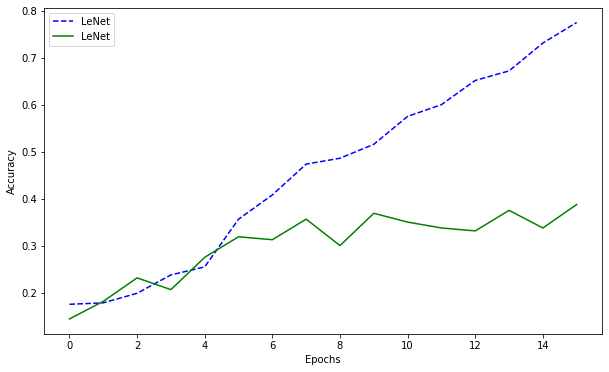

In [33]:
train_acc_lenet = training_history_lenet.history['accuracy']
val_acc_lenet = training_history_lenet.history['val_accuracy']

plt.figure(figsize=(10,6))
xaxis = range(nb_epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(xaxis,
         train_acc_lenet, 
         label = 'LeNet',
         ls='--',
         color = 'blue')
plt.plot(xaxis,
         val_acc_lenet, 
         label = 'LeNet',
         color = 'green')
plt.legend()
plt.show()

In [34]:
y_pred_lenet = lenet.predict(X_test_lenet)

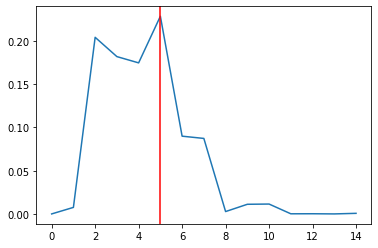

In [39]:
plt.plot(range(df['length'].max()), y_pred_lenet[0]);
plt.axvline(y_pred_lenet[0].argmax(), color='red');

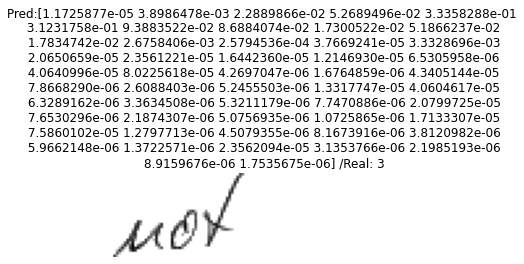

In [29]:
plt.imshow(X_test_lenet[0], cmap='gray');
plt.axis('off');
plt.title("Pred:" + str(y_pred_lenet[0]) + ' /Real: ' + str(y_test[0]));

### Regressor

In [ ]:
# from sklearn.neural_network import MLPRegressor

# mlp_reg = MLPRegressor(
#     solver='lbfgs', 
#     activation='relu',
#     alpha=1e-4, 
#     hidden_layer_sizes=(64, 256, 1024), 
#     max_iter=10_000,
#     random_state=42
# )
# # {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (64, 256, 1024)}
# mlp_reg.fit(X_train, y_train)

# print(mlp_reg.score(X_test, y_test))
# y_pred = mlp_reg.predict(X_test)
# # y_pred_proba = mlp.predict_proba(X_test)


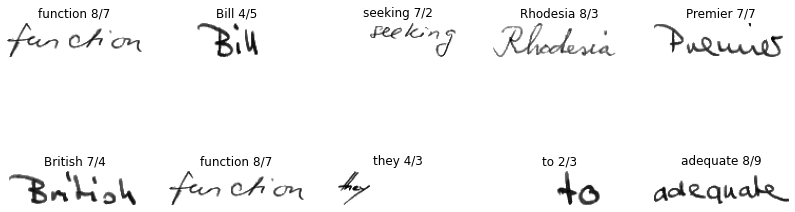

In [ ]:
plt.figure(figsize=(14, 5))
j = 1
for i in np.random.randint(low=800, high=1000, size=[10]):
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(X_test[i - 800].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length) + '/' + str(y_pred[i - 800]))
    j+=1

### With GridSearch

- Solver: "lbfgs"
    Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier


# mlp = MLPClassifier(solver='lbfgs', random_state=42, max_iter=1_000)

# params = {
#     'activation' : ['logistic', 'tanh', 'relu'],
#     'alpha': [1e-5, 1e-4, 1e-3],
#     'hidden_layer_sizes': [(2**6, 2**8), (2**6, 2**8, 2**10)],
#     # 'max_iter': [200, 500, 1_000]
# }

# grid_search = GridSearchCV(mlp, params)
# grid_search.fit(X_train, y_train)

# print('best params', grid_search.best_params_)
# print(grid_search.score(X_test, y_test))

# y_pred = grid_search.predict(X_test)
# y_pred_proba = grid_search.predict_proba(X_test)

In [ ]:
# ld_util.show_mlp_result_for_row(X_test, y_test, y_pred, y_pred_proba, 0)

## Linear

In [ ]:
from sklearn.linear_model import LinearRegression


X_lin_train, X_lin_test, y_lin_train, y_lin_test = train_test_split(df[['w', 'h']], df['length'], test_size=0.2)

lr = LinearRegression()
lr.fit(X_lin_train, y_lin_train)
score = lr.score(X_lin_test, y_lin_test)
y_lin_test_pred = lr.predict(X_lin_test)

print("Score: ", score)

Score:  0.7963669347071054


In [ ]:
for i in range(10):
    pred = round(y_lin_test_pred[i])
    real = y_lin_test.iloc[i] 
    print('predicted: ',pred , 'real:', real)

predicted:  3 real: 3
predicted:  3 real: 3
predicted:  12 real: 14
predicted:  7 real: 9
predicted:  4 real: 4
predicted:  9 real: 8
predicted:  4 real: 3
predicted:  2 real: 2
predicted:  2 real: 2
predicted:  6 real: 5


# TODOs

- Add rotation to letters to data gen
